![](/images/blog/mle-scaled-mean.png)

It's pretty common to run into statistical models that fit some kind of normalization factors that can be used to scale different data points to a common, comparable scale. When this happens to a [location-scale family distribution](https://en.wikipedia.org/wiki/Location%E2%80%93scale_family) like the normal distribution, estimating the mean parameter of such a scaled distribution is pretty straightforward. In many genomics contexts, however, non-location-scale distributions such as the [Poisson](https://en.wikipedia.org/wiki/Poisson_distribution) or [negative binomial (NB)](https://en.wikipedia.org/wiki/Negative_binomial_distribution) distribution are used quite often. For example, it's common to model RNA-seq read counts using NB distributions scaled by the library size (i.e., some measure of the total sequencing depth). In this post, we'll take a deep dive into how to estimate the parameters of these "scaled" statistical models.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gilgi/gilgi.github.com/blob/src/posts/mle_scaled_mean.ipynb)

<!-- TEASER_END -->

In [0]:
!pip install lib5c

In [0]:
import numpy as np
import scipy.stats as stats
from scipy.optimize import newton
from scipy.special import gammaln
import matplotlib.pyplot as plt
import seaborn as sns

from lib5c.util.distributions import freeze_distribution

sns.set_style('ticks')
np.random.seed(42)

In [0]:
def check_opt(f, guess, scale):
    xs = np.linspace(guess - scale*np.finfo(float).eps, guess + scale*np.finfo(float).eps, 101)
    ys = np.array([f(x) for x in xs])
    plt.plot(xs, ys)
    ylim = (ys[np.isfinite(ys)].min(), ys[np.isfinite(ys)].max())
    plt.vlines(guess, ylim[0], ylim[1], color='r')
    plt.xlim(xs.min(), xs.max())
    plt.ylim(*ylim)

## 0. Introduction

Say we want to perform maximum likelihood estimation for the mean $\mu$ of some observed data $(x_i)_{i=1}^n$. Moreover, say we believe that our different observations are not all on the same scale, but have instead been each influenced by a different scaling perturbation $(b_i)_{i=1}^n$ such that $\mathrm{E}[X_i] = \mu b_i$.

For example, our observed data $(x_i)_{i=1}^n$ may be sequencing read counts across $n$ high throughput sequencing experiments, which are influenced by the total sequencing depth in each experiment $(b_i)_{i=1}^n$.

This document will walk through how this kind of maximum likelihood estimation might be performed for a variety of choices of distribution family and assumptions about the data generating process.

## 1. Setup (scaling before noise)

We assume that the observed raw count in the $i$th replicate is a random variable $X_i$ following

$$X_i \sim D(\mu b_i, \ldots)$$

where $\mu$ is a normalized mean value, $b_i$ is a normalization factor for the $i$th replicate, and $D$ represents an arbitrary distribution family which may take other parameters (indicated by the $\ldots$, we constrain these to not depend on $b_i$).

We want to estimate $\mu$ given data $(x_i)_{i=1}^n$ and associated normalization factors $(b_i)_{i=1}^n$.

The log likelihood is

$$\log \mathcal{L}(\mu) = \sum_{i=1}^n \log f(x_i; \mu b_i, \ldots)$$

where $f(x_i; \mu, \ldots)$ is the PMF or PDF of $D(\mu, \ldots)$.

## 2. Normal (scaling before noise)

The normal PDF is

$$f(x; \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$

Plugging this in to our scaling-before-noise log likelihood function, we get

\begin{align}
\log \mathcal{L}(\mu) &= \sum_{i=1}^n \log \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x_i-\mu b_i)^2}{2\sigma^2}} \\
&= \sum_{i=1}^n -\frac{1}{2} \log 2\pi\sigma^2 - \frac{(x_i-\mu b_i)^2}{2\sigma^2} \\
&= -\frac{n}{2} \log 2\pi\sigma^2 - \frac{1}{2\sigma^2} \sum_{i=1}^n  (x_i-\mu b_i)^2
\end{align}

The derivative with respect to $\mu$ is

\begin{align}
\frac{d}{d\mu} \log \mathcal{L}(\mu) &= \frac{d}{d\mu} \left[ -\frac{n}{2} \log 2\pi\sigma^2 - \frac{1}{2\sigma^2} \sum_{i=1}^n  (x_i-\mu b_i)^2 \right] \\
&= -\frac{1}{2\sigma^2} \sum_{i=1}^n \frac{d}{d\mu} (x_i-\mu b_i)^2 \\
&= \frac{1}{2\sigma^2} \sum_{i=1}^n 2b_i(x_i-\mu b_i) \\
&= \frac{1}{\sigma^2} \sum_{i=1}^n b_i(x_i-\mu b_i)
\end{align}

Setting this to zero to look for critical points we find

\begin{align}
0 &= \frac{1}{\sigma^2} \sum_{i=1}^n b_i(x_i-\hat{\mu} b_i) \\
0 &= \sum_{i=1}^n b_i(x_i-\hat{\mu} b_i)
\end{align}

I don't actually know how to solve these equations with summations in them so let's assume $n=2$, then

\begin{align}
0 &= \sum_{i=1}^2 b_i(x_i-\hat{\mu} b_i) \\
0 &= b_1(x_1-\hat{\mu} b_1) + b_2(x_2-\hat{\mu} b_2) \\
0 &= b_1 x_1-\hat{\mu} b_1^2 + b_2 x_2 - \hat{\mu} b_2^2 \\
\hat{\mu} b_1^2 + \hat{\mu} b_2^2 &= b_1 x_1 + b_2 x_2 \\
\hat{\mu} (b_1^2 + b_2^2) &= b_1 x_1 + b_2 x_2 \\
\hat{\mu} &= \frac{b_1 x_1 + b_2 x_2}{b_1^2 + b_2^2}
\end{align}

Extrapolating this back to the general case we find

$$\hat{\mu} = \frac{\sum_{i=1}^n b_i x_i}{\sum_{i=1}^n b_i^2}$$

Define the normalized data $(y_i)_{i=1}^n$ as

$$y_i = x_i / b_i$$

Then in terms of the normalized data the MLE for $\hat{\mu}$ is

$$\hat{\mu} = \frac{\sum_{i=1}^n b_i^2 y_i}{\sum_{i=1}^n b_i^2}$$

which is just a weighted average of the normalized data, weighted by the squares of the bias factors.

We can check that this is correct by plotting the log likelihood function and overlaying our estimate:

(1.6666666666666667, 1.6679362887677078, 4.1341335782527215)
(True, True)


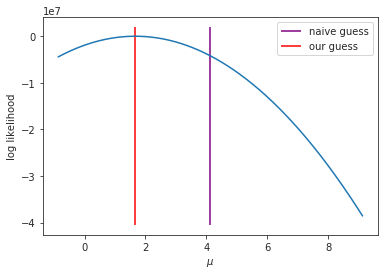

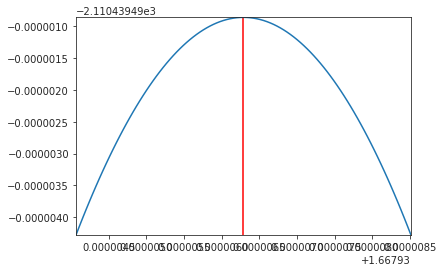

In [0]:
n = 1000
mu = 5./3
bs = np.exp(2*np.random.normal(size=n))
sigma = 2.
xs = stats.norm(mu*bs, sigma).rvs()

def log_likelihood(mu_hat):
    return np.sum(stats.norm(mu_hat * bs, sigma).logpdf(xs))

naive_guess = np.mean(xs / bs)
mu_hats = np.linspace(naive_guess - 5, naive_guess + 5, 1000)
lls = np.array([log_likelihood(m) for m in mu_hats])
our_guess = np.average(xs / bs, weights=bs**2)
plt.plot(mu_hats, lls)
ylim = plt.ylim()
plt.vlines(naive_guess, ylim[0], ylim[1], color='purple', label='naive guess')
plt.vlines(our_guess, ylim[0], ylim[1], color='r', label='our guess')
plt.ylabel('log likelihood')
plt.xlabel(r'$\mu$')
plt.legend()
print(mu, our_guess, naive_guess)
print(log_likelihood(our_guess) >= np.max(lls[mu_hats > 0]),
      log_likelihood(our_guess) >= log_likelihood(naive_guess))
plt.figure()
check_opt(log_likelihood, our_guess, 1e10)

Intuitively, since homoscedastic noise with variance $\sigma^2$ is applied after scaling, the "shrinking" of observed data points with larger normalization factors that results from the normalization process also shrinks the variance of the associated normalized data points.

Mathematically:

$$\textrm{Var}[X_i] = \sigma^2\; , \quad Y_i = X_i / b_i$$

so

\begin{align}
\textrm{Var}[Y_i] &= \textrm{Var}[X_i / b_i] \\
&= \frac{1}{b_i^2}\textrm{Var}[X_i] \\
&= \frac{1}{b_i^2}\sigma^2
\end{align}

noting the appearance of the $1/b_i^2$ factor corresponding to the weights (we want to weigh the observations according to their precision, which is the inverse of their variance).

Visually:

(3.8687292920719867, 0.42985881023022077)
(9.0, 9.0)


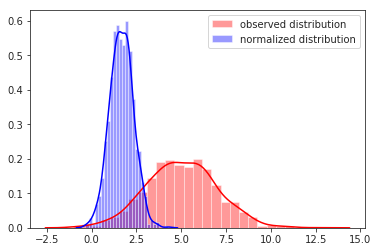

In [0]:
n = 1000
mu = 5./3
b = 3.
sigma = 2.
xs = stats.norm(mu*b, sigma).rvs(size=n)
ys = xs / b
ax = plt.gca()
sns.distplot(xs, color='red', label='observed distribution', ax=ax)
sns.distplot(ys, color='blue', label='normalized distribution', ax=ax)
plt.legend()
var_xs = np.var(xs, ddof=1)
var_ys = np.var(ys, ddof=1)
print(var_xs, var_ys)
print(var_xs / var_ys, b**2)

Note that $\mathrm{Var}[X_i] = \sigma^2$ regardless of $b_i$.

## 3. Alternative setup (scaling after noise)

We could assume a different model:

$$\frac{X_i}{b_i} \sim D(\mu, \sigma^2)$$

This is equivalent to

\begin{align}
Z_i &\sim D(\mu, \sigma^2) \\
X_i &= Z_i b_i
\end{align}

The intuition for this model is that first a hidden value $Z_i$ is drawn from the noisy distribution, and subsequently a deterministic process scales this hidden value to $X_i$, the random variable we actually observe.

This is different from the previous model, in which the mean was scaled before the random variable was drawn.

Noting that $Y_i = X_i / b_i$ is a random variable representing the normalized value, we could also write this as

$$Y_i \sim D(\mu, \sigma^2)$$

which intuitively suggests that our distribution $D(\mu, \sigma^2)$ describes the distribution of the normalized data $(y_i)_{i=1}^n$.

In other words, once we have normalized the data, we are free to fit parameters without regard to the normalization factors $(b_i)_{i=1}^n$ because they no longer appear in this formulation of the model.

## 4. Normal (scaling after noise)

In the specific case that $D(\mu, \sigma^2)$ is a normal distribution $\mathcal{N}(\mu, \sigma^2)$, we can write

\begin{align}
\frac{X_i}{b_i} &\sim \mathcal{N}(\mu, \sigma^2) \\
X_i &\sim b_i \times \mathcal{N}(\mu, \sigma^2) \\
X_i &\sim \mathcal{N}(\mu b_i, \sigma^2 b_i^2)
\end{align}

To visually see that all of these are equivalent:

(37.98004409296156, 4.220004899217952)


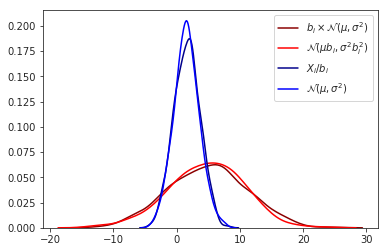

In [0]:
n = 1000
mu = 5./3
b = 3.
sigma = 2.
xs_1 = b * stats.norm(mu, sigma).rvs(size=n)
xs_2 = stats.norm(mu * b, sigma * b).rvs(size=n)
ys_1 = xs_1 / b
ys_2 = stats.norm(mu, sigma).rvs(size=1000)
ax = plt.gca()
sns.distplot(xs_1, hist=False, color='darkred', label=r'$b_i \times \mathcal{N}(\mu, \sigma^2)$', ax=ax)
sns.distplot(xs_2, hist=False, color='red', label=r'$\mathcal{N}(\mu b_i, \sigma^2 b_i^2)$', ax=ax)
sns.distplot(ys_1, hist=False, color='darkblue', label=r'$X_i / b_i$', ax=ax)
sns.distplot(ys_2, hist=False, color='blue', label=r'$\mathcal{N}(\mu, \sigma^2)$', ax=ax)
plt.legend()
var_xs = np.var(xs_1, ddof=1)
var_ys = np.var(ys_1, ddof=1)
print(var_xs, var_ys)

Note that $\mathrm{Var}[Y_i] = \sigma^2$ regardless of $b_i$.

Based on our logic in **3. Alternative setup (scaling after noise)**, we expect

$$Y_i \sim \mathcal{N}(\mu, \sigma^2)$$

so

$$\hat{\mu} = \bar{y} = \frac{1}{n}\sum_{i=1}^n y_i$$

We can check that this is correct by plotting the log likelihood function and overlaying our estimate:

(1.6666666666666667, 1.7051007500272348, 1.7051007500272348)
(True, True)


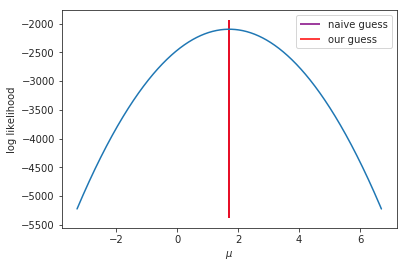

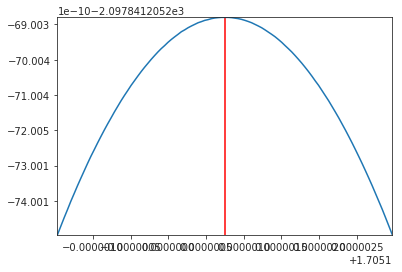

In [0]:
n = 1000
mu = 5./3
bs = np.exp(2 * np.random.normal(size=n))
sigma = 2.
xs = bs * stats.norm(mu, sigma).rvs(size=n)

def log_likelihood(mu_hat):
    return np.sum(stats.norm(mu_hat * bs, sigma * bs).logpdf(xs))

naive_guess = np.mean(xs / bs)
mu_hats = np.linspace(naive_guess - 5, naive_guess + 5, 1000)
lls = np.array([log_likelihood(m) for m in mu_hats])
our_guess = np.mean(xs / bs)
plt.plot(mu_hats, lls)
ylim = plt.ylim()
plt.vlines(naive_guess, ylim[0], ylim[1], color='purple', label='naive guess')
plt.vlines(our_guess, ylim[0], ylim[1], color='r', label='our guess')
plt.ylabel('log likelihood')
plt.xlabel(r'$\mu$')
plt.legend()
print(mu, our_guess, naive_guess)
print(log_likelihood(our_guess) >= np.max(lls[mu_hats > 0]),
      log_likelihood(our_guess) >= log_likelihood(naive_guess))
plt.figure()
check_opt(log_likelihood, our_guess, 1e10)

## 5. Poisson (scaling before noise)

The Poisson PMF is

$$f(x; \mu) = \frac{\mu^x e^{-\mu}}{x!}$$

Plugging this in to our scaling-before-noise log likelihood function, we get

\begin{align}
\log \mathcal{L}(\mu) &= \sum_{i=1}^n \log \frac{(\mu b_i)^{x_i} e^{-\mu b_i}}{x_i !} \\
&= \sum_{i=1}^n \left( x_i \log \mu b_i  - \mu b_i - \log x_i !\right)
\end{align}

The derivative with respect to $\mu$ is

\begin{align}
\frac{d}{d\mu} \log \mathcal{L}(\mu) &= \frac{d}{d\mu} \left[ \sum_{i=1}^n \left( x_i \log \mu b_i  - \mu b_i - \log x_i !\right) \right] \\
&= \sum_{i=1}^n \left( x_i \frac{d}{d\mu} \log \mu b_i  - \frac{d}{d\mu} \mu b_i - \frac{d}{d\mu} \log x_i !\right) \\
&= \sum_{i=1}^n \left( \frac{x_i}{\mu} - b_i \right)
\end{align}

Setting this to zero to look for critical points we find

\begin{align}
0 &= \sum_{i=1}^n \left( \frac{x_i}{\hat{\mu}} - b_i \right) \\
0 &= \frac{1}{\hat{\mu}} \sum_{i=1}^n \left( x_i - \hat{\mu} b_i \right) \\
0 &= \sum_{i=1}^n \left( x_i - \hat{\mu} b_i \right)
\end{align}

I don't actually know how to solve these equations with summations in them so let's assume $n=2$, then

\begin{align}
0 &= \sum_{i=1}^2 \left( x_i - \hat{\mu} b_i \right) \\
0 &= x_1-\hat{\mu} b_1 + x_2-\hat{\mu} b_2 \\
\hat{\mu} b_1 + \hat{\mu} b_2 &= x_1 + x_2 \\
\hat{\mu} &= \frac{x_1 + x_2}{b_1 + b_2}
\end{align}

Extrapolating this back to the general case we find

$$\hat{\mu} = \frac{\sum_{i=1}^n x_i}{\sum_{i=1}^n b_i}$$

Define the normalized data $(y_i)_{i=1}^n$ as

$$y_i = x_i / b_i$$

Then in terms of the normalized data the MLE for $\hat{\mu}$ is

$$\hat{\mu} = \frac{\sum_{i=1}^n b_i y_i}{\sum_{i=1}^n b_i}$$

which is just a weighted average of the normalized data, weighted by the bias factors.

We can check that this is correct by plotting the log likelihood function and overlaying our estimate:

(1.6666666666666667, 1.6666666962108134, 1.1984738164238264)
(True, True)


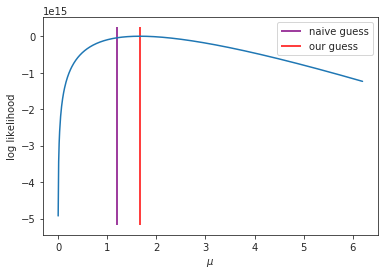

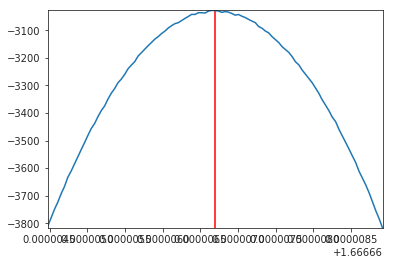

In [0]:
n = 1000
mu = 5./3
bs = np.exp(10 * np.random.normal(size=n))
sigma = 2.
xs = stats.poisson(mu * bs).rvs()

def log_likelihood(mu_hat):
    return np.sum(stats.poisson(mu_hat * bs).logpmf(xs))

naive_guess = np.mean(xs / bs)
mu_hats = np.linspace(naive_guess - 5, naive_guess + 5, 1000)
lls = np.array([log_likelihood(m) for m in mu_hats])
our_guess = np.average(xs / bs, weights=bs)
plt.plot(mu_hats, lls)
ylim = plt.ylim()
plt.vlines(naive_guess, ylim[0], ylim[1], color='purple', label='naive guess')
plt.vlines(our_guess, ylim[0], ylim[1], color='r', label='our guess')
plt.ylabel('log likelihood')
plt.xlabel(r'$\mu$')
plt.legend()
print(mu, our_guess, naive_guess)
print(log_likelihood(our_guess) >= np.max(lls[mu_hats > 0]),
      log_likelihood(our_guess) >= log_likelihood(naive_guess))
plt.figure()
check_opt(log_likelihood, our_guess, 1e10)

Intuitively, the variance is still applied after scaling (just like in section **2. Normal (scaling before noise)**), but this time the variance is not homoscedastic. Instead it is Poisson noise, which follows a linear mean-variance relationship.

Mathematically:

$$\textrm{Var}[X_i] = \textrm{E}[X_i] = \mu b_i\; , \quad Y_i = X_i / b_i$$

so

\begin{align}
\textrm{Var}[Y_i] &= \textrm{Var}[X_i / b_i] \\
&= \frac{1}{b_i^2}\textrm{Var}[X_i] \\
&= \frac{\mu b_i}{b_i^2} \\
&= \frac{1}{b_i}\mu
\end{align}

noting the appearance of the $1/b_i$ factor corresponding to the weights (we want to weigh the observations according to their precision, which is the inverse of their variance).

Visually:

(1.701, 1.6666666666666667)
(0.6139907685463241, 0.5555555555555556)
(5.103, 5.525916916916917, 5.0)


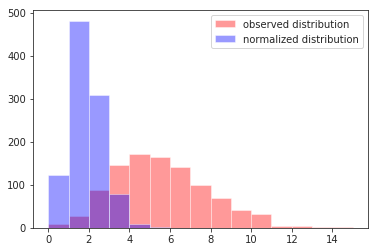

In [0]:
n = 1000
mu = 5./3
b = 3.
xs = stats.poisson(mu*b).rvs(size=n)
ys = xs / b
ax = plt.gca()
sns.distplot(xs, color='red', label='observed distribution', kde=False, bins=np.arange(max(xs)+1), ax=ax)
sns.distplot(ys, color='blue', label='normalized distribution', kde=False, bins=np.arange(max(xs)+1), ax=ax)
plt.legend()
mean_xs = np.mean(xs)
mean_ys = np.mean(ys)
var_xs = np.var(xs, ddof=1)
var_ys = np.var(ys, ddof=1)
print(mean_ys, mu)
print(var_ys, mu/b)
print(mean_xs, var_xs, mu*b)

Note that $\mathrm{E}[Y_i] = \mu$ regardless of $b_i$, that $\mathrm{Var}[Y_i] = \mu/b_i$, and that $\mathrm{Var}[X_i] = \mathrm{E}[X_i] = \mu b_i$.

## 6. Poisson (scaling after noise)

From **3. Alternative setup (scaling after noise)** above, our alternative Poisson model would be

$$Y_i \sim \mathrm{Poisson}(\mu)$$

However, the normalized data random variable $Y_i = X_i / b_i$ is no longer an integer (since there are no constraints on the $(b_i)_{i=1}^n$), so the normalized data cannot be described by a Poisson distribution.

## 7. Negative binomial (no scaling, constant dispersion)

The negative binomial distribution is more complicated than the Poisson or normal distributions, so as a warm-up exercise we will derive the maximum likelihood estimator for the mean of a negative binomial distribution at constant dispersion without any normalization factors.

Our model is simply

$$X \sim \mathrm{NB}(\mu, \alpha)$$

where $\mathrm{NB}(\mu, \alpha)$ is a negative binomial distribution parameterized in terms of its mean $\mu$ and dispersion $\alpha$.

The PMF associated with this parameterization is

$$f(x; \mu, \alpha) = \frac{\Gamma\left(\frac{1}{\alpha}+x\right)}{x! \Gamma\left(\frac{1}{\alpha}\right)} \left(\frac{\frac{1}{\alpha}}{\frac{1}{\alpha} + \mu}\right)^{1/\alpha} \left(\frac{\mu}{\frac{1}{\alpha} + \mu}\right)^x$$

Plugging this in to a no-scaling log likelihood function

$$\log \mathcal{L}(\mu) = \sum_{i=1}^n \log f(x_i; \mu, \alpha)$$

we get

\begin{align}
\log \mathcal{L}(\mu) &= \sum_{i=1}^n \log \left[\frac{\Gamma\left(\frac{1}{\alpha}+x_i\right)}{x_i! \Gamma\left(\frac{1}{\alpha}\right)} \left(\frac{\frac{1}{\alpha}}{\frac{1}{\alpha} + \mu}\right)^{1/\alpha} \left(\frac{\mu}{\frac{1}{\alpha} + \mu}\right)^{x_i}\right] \\
&= \sum_{i=1}^n \left[ \log\Gamma\left(\frac{1}{\alpha}+x_i\right) - \log(x_i!) - \log\Gamma\left(\frac{1}{\alpha}\right) + \frac{1}{\alpha}\log\frac{1}{\alpha} - \frac{1}{\alpha}\log\left(\frac{1}{\alpha}+\mu\right) + x_i\log\mu - x_i\log\left(\frac{1}{\alpha} + \mu \right)\right]
\end{align}

The derivative with respect to $\mu$ is

\begin{align}
\frac{d}{d\mu} \log\mathcal{L}(\mu) &= \frac{d}{d\mu} \left[\sum_{i=1}^n \left[ \log\Gamma\left(\frac{1}{\alpha}+x_i\right) - \log(x_i!) - \log\Gamma\left(\frac{1}{\alpha}\right) + \frac{1}{\alpha}\log\frac{1}{\alpha} - \frac{1}{\alpha}\log\left(\frac{1}{\alpha}+\mu\right) + x_i\log\mu - x_i\log\left(\frac{1}{\alpha} + \mu \right)\right]\right] \\
%&= \sum_{i=1}^n \left[ \frac{d}{d\mu}\log\Gamma\left(\frac{1}{\alpha}+x_i\right) - \frac{d}{d\mu}\log(x_i!) - \frac{d}{d\mu}\log\Gamma\left(\frac{1}{\alpha}\right) + \frac{d}{d\mu}\frac{1}{\alpha}\log\frac{1}{\alpha} - \frac{d}{d\mu}\frac{1}{\alpha}\log\left(\frac{1}{\alpha}+\mu\right) + \frac{d}{d\mu}x_i\log\mu - \frac{d}{d\mu}x_i\log\left(\frac{1}{\alpha} + \mu \right)\right] \\
&= \sum_{i=1}^n \left[-\frac{\frac{1}{\alpha}}{\frac{1}{\alpha}+\mu} + \frac{x_i}{\mu} - \frac{x_i}{\frac{1}{\alpha}+\mu}\right] \\
&= \sum_{i=1}^n \left[\frac{x_i}{\mu} - \frac{x_i+\frac{1}{\alpha}}{\frac{1}{\alpha} + \mu}\right] \\
&= \sum_{i=1}^n \frac{x_i\left(\frac{1}{\alpha} + \mu\right) - \mu\left(x_i + \frac{1}{\alpha}\right)}{\mu\left(\frac{1}{\alpha} + \mu \right)} \\
&= \sum_{i=1}^n \frac{x_i\frac{1}{\alpha} + x_i\mu - x_i\mu - \mu \frac{1}{\alpha}}{\mu \frac{1}{\alpha} + \mu^2} \\
&= \sum_{i=1}^n \frac{x_i\frac{1}{\alpha} - \mu \frac{1}{\alpha}}{\mu \frac{1}{\alpha} + \mu^2} \\
&= \sum_{i=1}^n \frac{x_i - \mu }{\mu + \alpha\mu^2}
\end{align}

Setting this to zero to look for critical points we find

\begin{align}
0 &= \sum_{i=1}^n \frac{x_i - \hat{\mu} }{\hat{\mu} + \alpha\hat{\mu}^2} \\
0 &=  \sum_{i=1}^n (x_i - \hat{\mu})
\end{align}

I don't actually know how to solve these equations with summations in them so let's assume $n=2$, then

\begin{align}
0 &=  \sum_{i=1}^2 (x_i - \hat{\mu}) \\
0 &= x_1 - \hat{\mu} + x_2 - \hat{\mu} \\
2\hat{\mu} &= x_1 + x_2 \\
\hat{\mu} &= \frac{x_1 + x_2}{2}
\end{align}

Extrapolating this back to the general case we find

$$\hat{\mu} = \frac{1}{n}\sum_{i=1}^n x_i$$

This is just the sample mean of the $(x_i)_{i=1}^n$.

We can check that this is correct by plotting the log likelihood function and overlaying our estimate:

(1.6666666666666667, 1.786, 1.786)
(True, True)


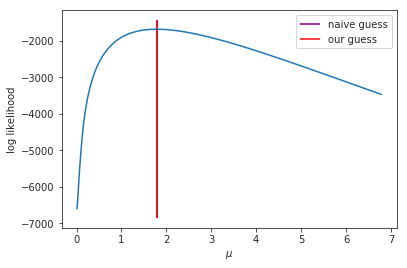

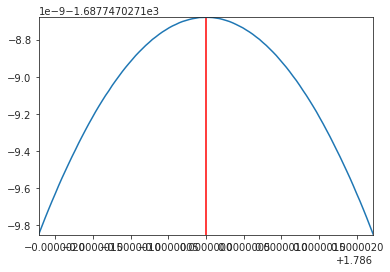

In [0]:
n = 1000
mu = 5./3
mus = np.ones(n) * mu
alpha = 0.1
alphas = np.ones(n) * alpha

def mvr(mean, disp):
    return mean + mean**2 * disp

xs = freeze_distribution(stats.nbinom, mus, mvr(mus, alphas)).rvs()

def log_likelihood(mu_hat):
    return np.sum(freeze_distribution(stats.nbinom, mu_hat*np.ones(n), mvr(mu_hat*np.ones(n), alphas)).logpmf(xs))

naive_guess = np.mean(xs)
mu_hats = np.linspace(naive_guess - 5, naive_guess + 5, 1000)
lls = np.array([log_likelihood(m) for m in mu_hats])
our_guess = np.mean(xs)
plt.plot(mu_hats, lls)
ylim = plt.ylim()
plt.vlines(naive_guess, ylim[0], ylim[1], color='purple', label='naive guess')
plt.vlines(our_guess, ylim[0], ylim[1], color='r', label='our guess')
plt.ylabel('log likelihood')
plt.xlabel(r'$\mu$')
plt.legend()
print(mu, our_guess, naive_guess)
print(log_likelihood(our_guess) >= np.max(lls[mu_hats > 0]),
      log_likelihood(our_guess) >= log_likelihood(naive_guess))
plt.figure()
check_opt(log_likelihood, our_guess, 1e10)

## 8. Negative binomial (scaling before noise, constant dispersion)

Our model is similar to the one in **7. Negative binomial (no scaling, constant dispersion)**, except that now we add back the normalization factors $(b_i)_{i=1}^n$:

$$X_i \sim \mathrm{NB}(\mu b_i, \alpha)$$

Following steps similar to those above, we find that the log likelihood under this model is

$$\log\mathcal{L}(\mu) = \sum_{i=1}^n \left[ \log\Gamma\left(\frac{1}{\alpha}+x_i\right) - \log(x_i!) - \log\Gamma\left(\frac{1}{\alpha}\right) + \frac{1}{\alpha}\log\frac{1}{\alpha} - \frac{1}{\alpha}\log\left(\frac{1}{\alpha}+\mu b_i\right) + x_i\log\mu b_i - x_i\log\left(\frac{1}{\alpha} + \mu b_i \right)\right]$$

and its derivative with respect to $\mu$ is

\begin{align}
\frac{d}{d\mu} \log\mathcal{L}(\mu) &= \frac{d}{d\mu} \left[\sum_{i=1}^n \left[ \log\Gamma\left(\frac{1}{\alpha}+x_i\right) - \log(x_i!) - \log\Gamma\left(\frac{1}{\alpha}\right) + \frac{1}{\alpha}\log\frac{1}{\alpha} - \frac{1}{\alpha}\log\left(\frac{1}{\alpha}+\mu b_i \right) + x_i\log\mu b_i - x_i\log\left(\frac{1}{\alpha} + \mu b_i \right)\right]\right] \\
&= \sum_{i=1}^n \left[-\frac{\frac{1}{\alpha} b_i}{\frac{1}{\alpha}+\mu b_i} + \frac{x_i}{\mu} - \frac{x_i b_i}{\frac{1}{\alpha}+\mu b_i}\right] \\
&= \sum_{i=1}^n \left[\frac{x_i}{\mu} - \frac{x_i b_i+\frac{1}{\alpha} b_i}{\frac{1}{\alpha} + \mu b_i}\right] \\
&= \sum_{i=1}^n \frac{x_i\left(\frac{1}{\alpha} + \mu b_i \right) - \mu\left(x_i b_i+\frac{1}{\alpha} b_i\right)}{\mu\left(\frac{1}{\alpha} + \mu b_i \right)} \\
&= \sum_{i=1}^n \frac{x_i\frac{1}{\alpha} + x_i\mu b_i - x_i\mu b_i - \frac{1}{\alpha}\mu b_i}{\mu \frac{1}{\alpha} + \mu^2 b_i} \\
&= \sum_{i=1}^n \frac{x_i\frac{1}{\alpha} - \frac{1}{\alpha}\mu b_i}{\mu \frac{1}{\alpha} + \mu^2 b_i} \\
&= \sum_{i=1}^n \frac{x_i - \mu b_i}{\mu + \alpha \mu^2 b_i}
\end{align}

$$%\frac{d}{d\mu} \log\mathcal{L}(\mu) = \sum_{i=1}^n \frac{x_i - \mu b_i }{\mu b_i + \alpha\mu^2 b_i^2}$$

We can set this to zero to look for critical points:

$$0 = \sum_{i=1}^n  \frac{x_i - \hat{\mu} b_i}{\hat{\mu} + \alpha \hat{\mu}^2 b_i} $$

I was not able to solve this analytically in the general case.

We can compute the second derivative of the log likelihood with respect to $\mu$, which will might be useful for numerical optimization:

\begin{align}
\frac{d^2}{d\mu^2} \log\mathcal{L}(\mu) &= \frac{d}{d\mu} \sum_{i=1}^n  \frac{x_i - \hat{\mu} b_i}{\hat{\mu} + \alpha \hat{\mu}^2 b_i} \\
&= \sum_{i=1}^n \left[-\frac{b_i}{\hat{\mu} + \alpha \hat{\mu}^2 b_i} - \frac{(1 + 2\alpha \hat{\mu} b_i) (x_i - \hat{\mu} b_i)}{(\hat{\mu} + \alpha \hat{\mu}^2 b_i)^2}\right]
\end{align}

In a separate notebook, we used 4 different methods to numerically find $\hat{\mu}$, verified that they all led to optimal estimates, and timed them to order them from fastest to slowest:

 1. Brent's method to find the root of the first derivative of the log likelihood function via `scipy.optimize.brentq()`.
 2. The secant method to find the root of the first derivative of the log likelihood function via `scipy.optimize.newton(..., fprime=None)`.
 3. Newton's method to find the root of the first derivative of the log likelihood function via `scipy.optimize.newton(..., fprime=fprime)`.
 4. Brent's method to find the minimum of the negative log likelihood function via `scipy.optimize.minimize_scalar(..., method='brent')`.

Our implementation of the negative log likelihood function might not be optimized for multiple evaluations, explaining why (4) is the slowest.

The second derivative of the log likelihood appears to be even more expensive to evaluate than the first derivative, which explains why Newton's method is slower than the secant method.

Brent's method is usually preferred to the secant method and appears to be faster in this case. One caveat is that we need to provide a bracket on $\hat{\mu}$ to use Brent's method. One possible approach would be to start with the interval $[10 \times \epsilon, 2\times \mu_{\textrm{naive}}]$ (where $\epsilon$ is machine epsilon and $\mu_{\textrm{naive}}=\frac{1}{n}\sum_{i=1}^n x_i/b_i$) and simply iteratively double the right endpoint of the interval until it brackets the root.

For illustrative purposes, the secant method implementation is shown below:

In [0]:
def fit_mu_hat(xs, bs, alpha):
    def f(mu_hat):
        return np.sum((xs - mu_hat*bs) / (mu_hat + alpha * mu_hat**2 * bs))
    res = newton(f, np.mean(xs/bs), tol=2*np.finfo(float).eps)
    return res

We can check that this is correct by plotting the log likelihood function and overlaying our estimate:

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log


(1.6666666666666667, 1.5995526836511573, 1.3914988365007313)
(True, True)


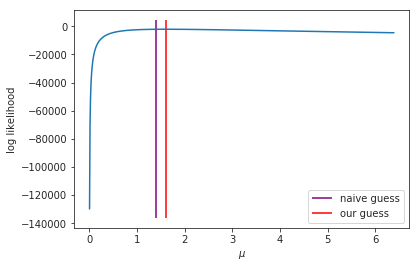

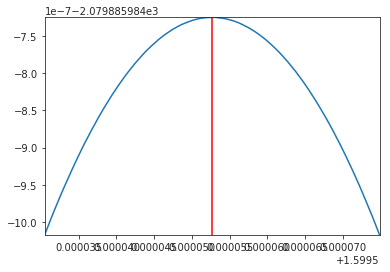

In [0]:
n = 1000
mu = 5./3
bs = np.exp(3 * np.random.normal(size=n))
alpha = 0.1
alphas = np.ones(n) * alpha

def mvr(mean, disp):
    return mean + mean**2 * disp

xs = freeze_distribution(stats.nbinom, mu*bs, mvr(mu*bs, alphas)).rvs()

#def log_likelihood(mu_hat):
#    return np.sum(freeze_distribution(stats.nbinom, mu_hat*bs, mvr(mu_hat*bs, alphas)).logpmf(xs))

def log_likelihood(mu_hat):
    def logpmf(k, m, phi):
        r = 1. / phi
        return gammaln(r+k) - gammaln(k+1) - gammaln(r) + r*np.log(r) - r*np.log(r+m) + k*np.log(m) - k*np.log(r+m)
    return np.sum(logpmf(xs, mu_hat*bs, alphas))

naive_guess = np.mean(xs / bs)
mu_hats = np.linspace(naive_guess - 5, naive_guess + 5, 1000)
lls = np.array([log_likelihood(m) for m in mu_hats])
our_guess = fit_mu_hat(xs, bs, alpha)
plt.plot(mu_hats, lls)
ylim = plt.ylim()
plt.vlines(naive_guess, ylim[0], ylim[1], color='purple', label='naive guess')
plt.vlines(our_guess, ylim[0], ylim[1], color='r', label='our guess')
plt.ylabel('log likelihood')
plt.xlabel(r'$\mu$')
plt.legend()
print(mu, our_guess, naive_guess)
print(log_likelihood(our_guess) >= np.max(lls[mu_hats > 0]),
      log_likelihood(our_guess) >= log_likelihood(naive_guess))
plt.figure()
check_opt(log_likelihood, our_guess, 1e11)

## 9. Negative binomial (no scaling, constant variance)

The negative binomial PMF, can also be parameterized in terms of mean $\mu$ and variance $\sigma^2$. This PMF is:

$$f(x; \mu, \sigma^2) = \frac{\Gamma\left(\frac{\mu^2}{\sigma^2-\mu}+x\right)}{x! \Gamma\left(\frac{\mu^2}{\sigma^2-\mu}\right)} \left(\frac{\sigma^2 - \mu}{\sigma^2}\right)^x \left(\frac{\mu}{\sigma^2}\right)^\frac{\mu^2}{\sigma^2-\mu} $$

We will attempt to repeat the warm-up exercise we did in **7. Negative binomial (no scaling, constant dispersion)**, but this time using the variance-based PMF.

Plugging the variance-based PMF in to our scaling-before-noise log likelihood function, we get

\begin{align}
\log \mathcal{L}(\mu) &= \sum_{i=1}^n \log \left[ \frac{\Gamma\left(\frac{\mu^2}{\sigma^2-\mu}+x_i\right)}{x_i! \Gamma\left(\frac{\mu^2}{\sigma^2-\mu}\right)} \left(\frac{\sigma^2 - \mu}{\sigma^2}\right)^{x_i} \left(\frac{\mu}{\sigma^2}\right)^\frac{\mu^2}{\sigma^2-\mu} \right] \\
&= \sum_{i=1}^n \left[ \log\Gamma\left(\frac{\mu^2}{\sigma^2-\mu}+x_i\right) - \log(x_i!) - \log\Gamma\left(\frac{\mu^2}{\sigma^2-\mu}\right) + x_i\log(\sigma^2 - \mu) - x_i\log \sigma^2 + \frac{\mu^2}{\sigma^2-\mu} \log \mu - \frac{\mu^2}{\sigma^2-\mu}\log \sigma^2 \right]
\end{align}

The derivative with respect to $\mu$ is

\begin{align}
\frac{d}{d\mu} \log \mathcal{L}(\mu) &= \frac{d}{d\mu} \sum_{i=1}^n \left[ \log\Gamma\left(\frac{\mu^2}{\sigma^2-\mu}+x_i\right) - \log(x_i!) - \log\Gamma\left(\frac{\mu^2}{\sigma^2-\mu}\right) + x_i\log(\sigma^2 - \mu) - x_i\log \sigma^2 + \frac{\mu^2}{\sigma^2-\mu} \log \mu - \frac{\mu^2}{\sigma^2-\mu}\log \sigma^2 \right] \\
&= \sum_{i=1}^n \left[ \frac{\mu(2\sigma^2 - \mu)}{(\sigma^2 - \mu)^2} \psi\left( \frac{\mu^2}{\sigma^2-\mu}+x_i \right) + \frac{\mu(2\sigma^2 - \mu)}{(\sigma^2 - \mu)^2} \psi\left( \frac{\mu^2}{\sigma^2-\mu}\right) - \frac{x_i}{\sigma_2 - \mu} + \frac{(\sigma^2 - \mu)(\mu+2\mu\log\mu) + \mu^2\log\mu - (\sigma^2 - \mu)2\mu\log\sigma^2 - \mu^2\log\sigma^2}{(\sigma^2 - \mu)^2} \right]
\end{align}

We can set this to zero to look for critical points, but I can't solve this equation analytically for $\hat{\mu}$:

$$0 = \sum_{i=1}^n \left[ \frac{\hat{\mu}(2\sigma^2 - \hat{\mu})}{(\sigma^2 - \hat{\mu})^2} \psi\left( \frac{\hat{\mu}^2}{\sigma^2-\hat{\mu}}+x_i \right) + \frac{\mu(2\sigma^2 - \hat{\mu})}{(\sigma^2 - \hat{\mu})^2} \psi\left( \frac{\hat{\mu}^2}{\sigma^2-\hat{\mu}}\right) - \frac{x_i}{\sigma_2 - \hat{\mu}} + \frac{(\sigma^2 - \hat{\mu})(\hat{\mu}+2\hat{\mu}\log\hat{\mu}) + \hat{\mu}^2\log\hat{\mu} - (\sigma^2 - \hat{\mu})2\hat{\mu}\log\sigma^2 - \hat{\mu}^2\log\sigma^2}{(\sigma^2 - \hat{\mu})^2} \right]$$

We can probably get estimates of $\hat{\mu}$ numerically, but based on the complexity of this parameterization I think it is better to stick to the dispersion-based parameterization instead.

We can briefly show that the naive guess does not work in the constant-variance case even when there is no scaling:

In [0]:
n = 1000
mu = 5./3
#bs = np.exp(0.1 * np.random.normal(size=n))
bs = np.ones(n)
sigma = 2.
sigmas = np.ones(n) * sigma
xs = freeze_distribution(stats.nbinom, mu*bs, sigmas).rvs()

def log_likelihood(mu_hat):
    return np.sum(np.log(freeze_distribution(stats.nbinom, mu_hat*bs, sigmas).pmf(xs)))

naive_guess = np.mean(xs / bs)
mu_hats = np.linspace(naive_guess - 5, naive_guess + 5, 1000)
lls = np.array([log_likelihood(m) for m in mu_hats])
our_guess = np.mean(xs / bs)
plt.plot(mu_hats, lls)
ylim = plt.ylim()
plt.vlines(our_guess, ylim[0], ylim[1], color='r')
plt.ylabel('log likelihood')
plt.xlabel(r'$\mu$')
print(mu, our_guess, naive_guess)
print(log_likelihood(our_guess) >= np.max(lls[mu_hats > 0]),
      log_likelihood(our_guess) >= log_likelihood(naive_guess))
plt.figure()
check_opt(log_likelihood, our_guess, 1e10)

This reinforces our earlier observation about the increased complexity of the variance-based parameterization.

## 10. Negative binomial (scaling after noise)

From **3. Alternative setup (scaling after noise)** above, our alternative negative binomial model would be

$$Y_i \sim \mathrm{NB}(\mu)$$

However, the normalized data random variable $Y_i = X_i / b_i$ is no longer an integer (since there are no constraints on the $(b_i)_{i=1}^n$), so the normalized data cannot be described by a negative binomial distribution.